# ДЗ к Урок 1. Кейс 1. EDA по Hourly Energy Consumption и Brent

## 1. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

import os

In [2]:
data = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
DUQ_MW    119068 non-null float64
dtypes: float64(1)
memory usage: 1.8 MB


In [5]:
data.describe()

,DUQ_MW
count,119068.000000
mean,1658.820296
std,301.740640
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


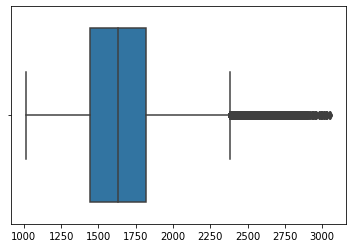

In [6]:
sns.boxplot(data.values)

In [8]:
# проверим пропуски
data['DUQ_MW'].isnull().sum()

0

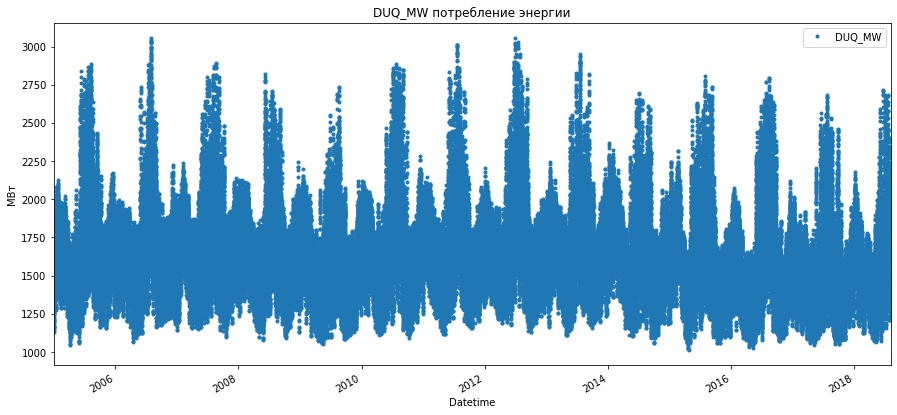

In [9]:
# Duquesne Light Co. (DUQ).
data.plot( style = '.', figsize = ( 15, 7 ), title = 'DUQ_MW потребление энергии' )
plt.ylabel ( 'МВт' );

Рис.1 потребление энергии за весь период ряда

### Обсуждение визуализации

- Основные статистики показали, что пропусков нет.
- Визуальный анализ показывает что:
    - Предъявленные данные имеют циклы
    - Нет провалов потребления.

## 2. Прочитайте базу Brent и сделайте ее перрасчет (ресемплинг) в представление по неделям , по месяцам.

## 3. Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.

## 4. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

In [15]:
data['date'] = data.index
data_2012 = data.loc[np.logical_and( np.logical_and( data['date'].dt.year == 2012 , data['date'].dt.month == 10), data['date'].dt.day > 20  )]

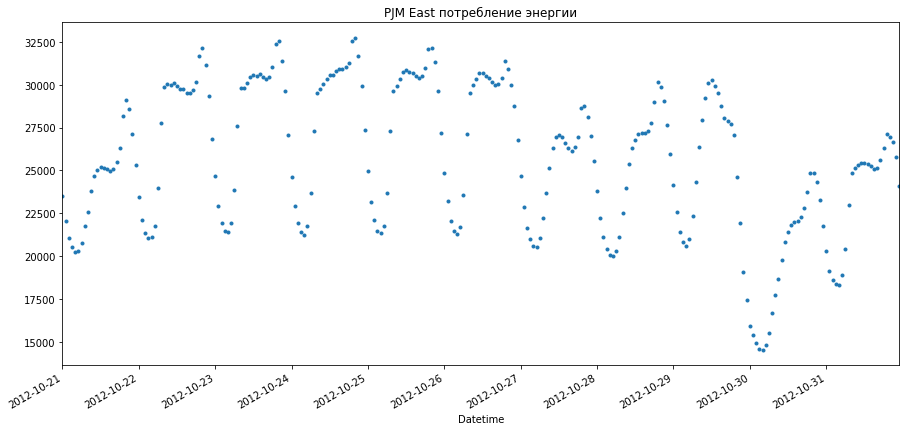

In [18]:
data_2012['PJME_MW'].plot( style='.', figsize=( 15, 7 ), title='PJM East потребление энергии' );

Рис.2 потребление энергии за 12 дней

Поскольку необычное явление длилось всего около 12 часов, то вероятно следует проверить информацию об авариях в этом отрезке сети. Кроме этого можно посмотреть на данные других регионов и оценить глобальность случивщейся аномалии. 


** Интересный инструмент для формирования описания данных по признакам из таблиц pandas_profiling. 
Пример подключения приведен ниже, следующие ячейки импорт модуля и формирование отчета

In [20]:
!pip install pandas_profiling

Looking in indexes: http://192.168.2.148:3141/dataware/release
     |████████████████████████████████| 133kB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 614kB 5.7MB/s eta 0:00:01
     |████████████████████████████████| 6.3MB 81kB/s eta 0:00:012
     |████████████████████████████████| 235kB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 3.6MB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 266kB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 92kB 6.9MB/s eta 0:00:011
     |████████████████████████████████| 20.2MB 19kB/s eta 0:00:011
     |████████████████████████████████| 307kB 5.9MB/s eta 0:00:01


     |████████████████████████████████| 51kB 5.6MB/s eta 0:00:011
     |████████████████████████████████| 215kB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 61kB 11.1MB/s eta 0:00:01
     |████████████████████████████████| 737kB 5.7MB/s eta 0:00:01
    Running setup.py install for htmlmin ... done
    Running setup.py install for wrapt ... done
    Running setup.py install for pyyaml ... done
    Running setup.py install for confuse ... done
    Running setup.py install for pandas-profiling ... done


In [21]:
import pandas_profiling

In [22]:
pandas_profiling.ProfileReport(data)

Рассмотрии поведение ряда "потребление энергии" в соседних регионов.

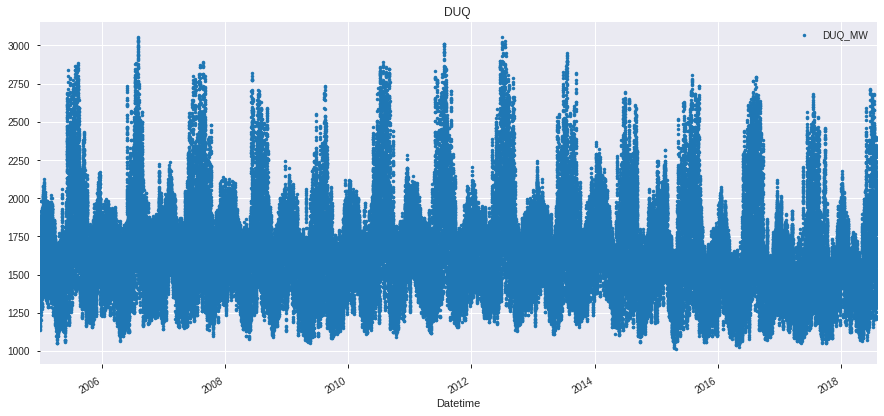

In [25]:
# Duquesne Light Co. (DUQ).
data_deok = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])
data_deok.plot( style='.', figsize=( 15, 7 ), title='DUQ ' );

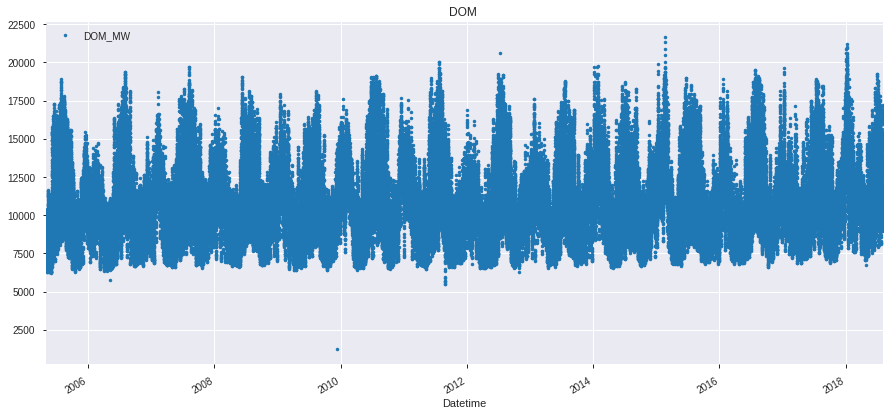

In [26]:
# Dominion Virginia Power (DOM)
data_dom = pd.read_csv('DOM_hourly.csv', index_col=[0], parse_dates=[0])
data_dom.plot( style='.', figsize=( 15, 7 ), title='DOM ' );

> > **Анализ аномалии 2012-10-30* в PJME data**
* Это не пропуск в в измерениях глобального отрезка сети
* Изменение потребления имеет гладкий непрерывный вид
* Другие области ничего такого не рисуют в этот день, но есть подобные аномалии в другие дни.
* Гипотезы: 
    * пропуск данных в подсетях
    * авария в подсети

Поскольку данные лежат в диапазоне от 14000МВт до 63000, то очевидно, что точность представления float64 избыточна. Перейдем к целым. Это позволит сократить объем занимаемой памяти.

In [27]:
# Теперь целые
data['PJME_MW'] = data['PJME_MW'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 2 columns):
PJME_MW    145366 non-null int64
date       145366 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.3 MB


## Brent 2010-2019
Перейдем к анализу второго примера. Цена нефти марки Brent (https://investfunds.ru/indexes/624/)
Данные из набора содержат дневные цены за период от 2010 до 2019 .

In [28]:
brent_data = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение
Дата,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59


In [29]:
brent_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2019-09-01 to 2010-09-01
Data columns (total 1 columns):
Значение    2667 non-null float64
dtypes: float64(1)
memory usage: 41.7 KB


In [30]:
brent_data.describe()

,Значение
count,2667.000000
mean,81.533547
std,26.349469
min,27.850000
25%,56.840000
50%,77.710000
75%,108.190000
max,126.900000


In [31]:
brent_data[brent_data['Значение'].isnull()].count()

Значение    0
dtype: int64

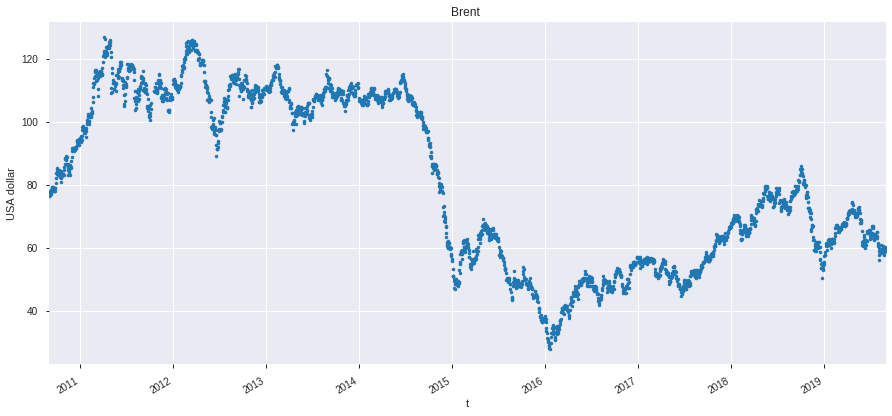

In [34]:
brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t');

Рис.3 Цена нефти с 2010 по 2019

Сравним два примера "Почасовое потребление энергии" и "подневные цены на нефть":


In [35]:
Compare_data = pd.DataFrame({'Energy':data['PJME_MW'].describe().values,'Brent':brent_data['Значение'].describe().values} )
Compare_data.index = data['PJME_MW'].describe().index
Compare_data

,Energy,Brent
count,145366.000000,2667.000000
mean,32080.222831,81.533547
std,6464.012166,26.349469
min,14544.000000,27.850000
25%,27573.000000,56.840000
50%,31421.000000,77.710000
75%,35650.000000,108.190000
max,62009.000000,126.900000


Видна разница в масштабах задачи на уровне количества примеров. Большой набор примеров в случае потреблени я энергии и сравнительно небольшой для цены на нефть. 
Однако, характер этих рядов существенно отличается. Энергия имеет выраженный порядок смены сезонов (рис.1) и дня и ночи (рис.2). Тогда как цена нефти не показывает никакой подобной динамики (Рис.3). Связать цены на нефть с календарем на этом этапе анализа не удалось

Оба ряда не содержат пропусков
В обоих последовательностях есть необычные артефакты: выброс 2012.10 в потреблении энергии и провал цены на нефть в 2014(природу которого нужно изучать).

## Обработка временных меток в Pandas

Временная индексация в большинстве случаев удобна и работает достаточно эффективно. Обычно даты и время используют в качестве индексов структуры DataFrame. Однако поскольку временные метки содекржат много дополнительной информации, то имеет смысл построить признаки, которые будут работать с ними и сопровождают изменения нашего временного ряда.

Для устранения влияния времени на результат и факторы при изучении взаимосвязанных рядов часто включают время события t в качестве независимой переменной в модель регрессии, что позволяет зафиксировать воздействие фактора t.

Попробуем реализовать подключение времени как признака , используя методы Pandas, который
предоставляет классы для обработки времени и даты разными способами. Существует типы данных для работы с временными данными: datetime64 и timedelta64.

Попробуем создать новую разметку времени. Для этого используют **метод pd.date_range(...)**. Пример 

In [36]:
my_data_time = pd.date_range('1/1/2019', periods=15, freq="D")
my_data_time

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15'],
              dtype='datetime64[ns]', freq='D')

создали разметку по дням начиная с 2019-01-01 и определили 15 дней. Посмотрим на формат описания подробней (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html) **pandas.date_range(start = <None или дата начала как строка в формате D.M.YYYY>, end = <None или дата конца>, periods= <None или число отсчетов>, freq=<None или можно задать дробность отсчета >, ...)**, где freq принимает значения :
    - 'D' - по умолчанию - интервал равен 1 дню,
    - 'M' - один месяц,
    - 'Y' - один год,
    - 'H' - один час,
    - 'T' - одна минута,
    - 'S' - секунда и т.д.
Все варианты представления интервалов можно проверить в документации функции. Еще один пример с месяцем как интервал времени

In [37]:
my_data_time_M = pd.date_range('1/1/2018', '1-1-2019', freq="M")
my_data_time_M

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [40]:
my_pd = pd.DataFrame(index = my_data_time_M, data = {'my_data': np.linspace(1,100,my_data_time_M.shape[0])})
my_pd.head()

,my_data
2018-01-31,1.0
2018-02-28,10.0
2018-03-31,19.0
2018-04-30,28.0
2018-05-31,37.0


Pandas понимает разные форматы задания дат. Используем **функцию для конвертации в дату-время**

In [41]:
DT = pd.to_datetime(pd.Series(['2019-01-01', 'May 1, 2019', '2019/01/10', '2019.02.13']))
DT

0   2019-01-01
1   2019-05-01
2   2019-01-10
3   2019-02-13
dtype: datetime64[ns]

Теперь взглянем на индексацию таблицы временем. Для этого используем специализированный объект **DatetimeIndex**

In [42]:
data.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

Эти индексы можно использовать для доступа к строкам.

In [43]:
data['2012-10-30 01:00:00':'2012-10-30 14:00:00']

,PJME_MW,date
Datetime,,
2012-10-30 01:00:00,15390,2012-10-30 01:00:00
2012-10-30 02:00:00,14955,2012-10-30 02:00:00
2012-10-30 03:00:00,14586,2012-10-30 03:00:00
2012-10-30 04:00:00,14544,2012-10-30 04:00:00
2012-10-30 05:00:00,14821,2012-10-30 05:00:00
2012-10-30 06:00:00,15526,2012-10-30 06:00:00
2012-10-30 07:00:00,16688,2012-10-30 07:00:00
2012-10-30 08:00:00,17734,2012-10-30 08:00:00
2012-10-30 09:00:00,18675,2012-10-30 09:00:00


Можно изменить частоту разметки через обращение **pd.asfreq(<длина нового интервала>)**

In [44]:
my_pd.asfreq('5D',method ='pad').head(10)

,my_data
2018-01-31,1.0
2018-02-05,1.0
2018-02-10,1.0
2018-02-15,1.0
2018-02-20,1.0
2018-02-25,1.0
2018-03-02,10.0
2018-03-07,10.0
2018-03-12,10.0
2018-03-17,10.0


и можно вернуться обратно переменив частоту отображения информации в таблице на более сжатую через **pd.resample("<задаем период оцифоровки>").<метод объединения результатов>()**

In [45]:
my_pd.resample("M").mean().head()

,my_data
2018-01-31,1.0
2018-02-28,10.0
2018-03-31,19.0
2018-04-30,28.0
2018-05-31,37.0


Кроме этого, к датам можно обращаться как к записям по отдельным полям. Например необходимо получить значение для дней, номер которых больше 3 и номер месяца больше 4  .

In [46]:
my_pd[(my_pd.index.day > 3) & (my_pd.index.month > 4) ]

,my_data
2018-05-31,37.0
2018-06-30,46.0
2018-07-31,55.0
2018-08-31,64.0
2018-09-30,73.0
2018-10-31,82.0
2018-11-30,91.0
2018-12-31,100.0


Список доступных полей можно посмотреть в документации. В частности в него входят следующие поля : year (получить год), month(месяц), day(день),hour(час), minute(минуты), week(недели), dayofyear(номер дня в году) и т.д. 

Посмотрим на наши ряды и попробуем получить новые переменные для описания модели из индексов типа дата-время. Начнем с ряда "Потребление энергии", который приподносит удивительный результат. Число уникальных индексов DatetimeIndex меньше числа наблюдений-строк.

Попробуем разобраться, что произошло. Добавим индекс как отдельную колонку. Исходная индексация по времени поддерживается объектом DatetimeIndex. Просто создадим новый столбец.

In [47]:
data['date'] = data.index
data.head()

,PJME_MW,date
Datetime,,
2002-12-31 01:00:00,26498,2002-12-31 01:00:00
2002-12-31 02:00:00,25147,2002-12-31 02:00:00
2002-12-31 03:00:00,24574,2002-12-31 03:00:00
2002-12-31 04:00:00,24393,2002-12-31 04:00:00
2002-12-31 05:00:00,24860,2002-12-31 05:00:00


In [48]:
ut = data['date'].unique()
print('число уникальных значений:   ',ut.shape[0],' : число наблюдений : ', data.shape[0])

число уникальных значений:    145362  : число наблюдений :  145366


Теперь посчитаем уникальные значения в data для колонки 'data'

In [49]:
count_data = data['date'].value_counts()
count_data.head()

2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2017-11-05 02:00:00    2
2012-08-16 00:00:00    1
Name: date, dtype: int64

Видно, что 4 года подряд в начале ноября однажды вносили данные за день 2 раза. Это очевидно, не верно. Что происходило, следует уточнять у автора данных. В качестве предположения можно подумать о вариантах, например, переход на зимнее время и тогда, в марте -апреле должен быть пропуск. Проверим март-апрель 2015 года

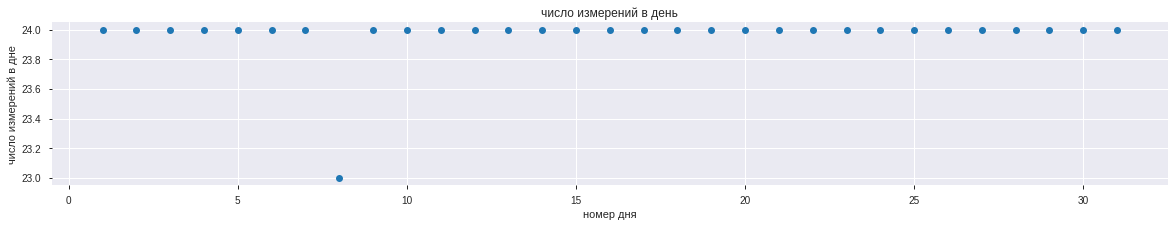

In [50]:
day_H=data['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

plt.figure(figsize=(20,3))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.show()

Видим, что один из дней марта имеет меньше измерений, чем остальные. Определим номер этого дня используя подсчет числа измерений по дням и сравнение этой цифры с идеальным значением 24.

In [51]:
Day_count = day_H.value_counts() 
Day_count[Day_count != 24]

8    23
Name: Datetime, dtype: int64

Посмотрим на этот дено поближе. Видим, что после 2-го часа сразу наступил 4-й.

In [52]:
data['2015-03-08 01:00:00':'2015-03-08 06:00:00'].index

DatetimeIndex(['2015-03-08 01:00:00', '2015-03-08 02:00:00',
               '2015-03-08 04:00:00', '2015-03-08 05:00:00',
               '2015-03-08 06:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

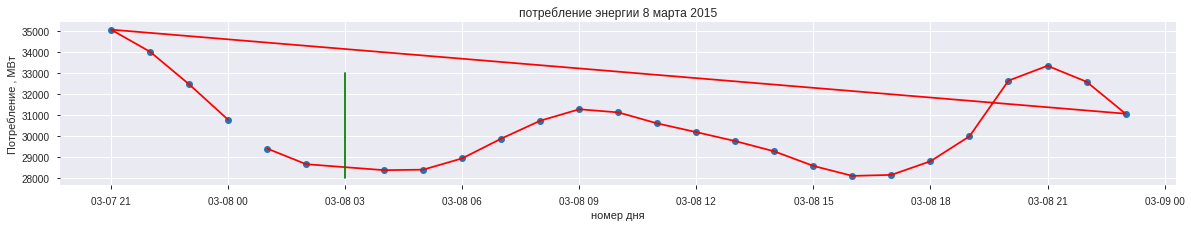

In [53]:
plt.figure(figsize=(20,3))
plt.plot(data['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,data['2015-03-07 21:00:00':'2015-03-08 23:00:00']['PJME_MW'].values, 'o')
plt.plot(data['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,data['2015-03-07 21:00:00':'2015-03-08 23:00:00']['PJME_MW'].values, 'r')
line_ = pd.to_datetime(pd.Series(['2015-03-08 03:00:00', '2015-03-08 03:00:00']))
plt.plot(line_,np.array([28000,33000]),'g')
plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии 8 марта 2015')

plt.show()

Рис. 4

Такой день в марте один - 8 марта 2015 :) . Гипотезу о переходе на летнее(зимнее) время можно считать доказаной. Найдем все такие аномалии по всему ряду.

выдвинутую гипотезу можно считать подтвержденной, т.к. очевидно, что есть разрыв в индексах. Эти разрывы необходимо пометить и преобразовать пользуясь какой-либо общей идеей.

In [54]:
day_H=data['2014-03-01 00:00:00':'2014-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2014 = Day_count[Day_count != 24].index
d2014

Int64Index([9], dtype='int64')

In [55]:
day_H=data['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2015 =Day_count[Day_count != 24].index
d2015

Int64Index([8], dtype='int64')

In [56]:
day_H=data['2016-03-01 00:00:00':'2016-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2016 =Day_count[Day_count != 24].index
d2016

Int64Index([13], dtype='int64')

In [57]:
day_H=data['2017-03-01 00:00:00':'2017-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2017 =Day_count[Day_count != 24].index
d2017

Int64Index([12], dtype='int64')

Попробуем решить проблему пропуска. Построим пропуск как интерполяцию между соседними меткам. Поскольку наше измерение является "фейком", то его назначение должно быть обосновано характером ряда и его типовым поведением. Наш ряд имеет гладкий характер в часовых диапазонах. Построим пропуск как среднее по 2-м соседям. Больше информации о заполнении пробелов во временных рядах можно посмотреть в (https://cyberleninka.ru/article/v/analiz-metodov-zapolneniya-propuskov-vo-vremennyh-ryadah-pokazateley-finansovyh-rynkov). Итак обработаем пропуски.


In [58]:
v1 = list((data['2014-03-09 02:00:00']['PJME_MW'].values + data['2014-03-09 04:00:00']['PJME_MW'].values) / 2)
print(v1)
v2 = list((data['2015-03-08 02:00:00']['PJME_MW'].values + data['2015-03-08 04:00:00']['PJME_MW'].values) / 2)
v3 = list((data['2016-03-13 02:00:00']['PJME_MW'].values + data['2016-03-13 04:00:00']['PJME_MW'].values) / 2)
v4 = list((data['2017-03-12 02:00:00']['PJME_MW'].values + data['2017-03-12 04:00:00']['PJME_MW'].values) / 2)
v =np.reshape([v1[0],v2[0],v3[0],v4[0]],(4,1))
v

df_data = pd.DataFrame(index = pd.to_datetime(pd.Series(['2014-03-09 03:00:00','2015-03-08 03:00:00','2016-03-13 03:00:00','2017-03-12 03:00:00'])), columns =['PJME_MW'] , data = v) 
df_data['date'] = df_data.index
df_data.head()
#
data = data.append(df_data,sort = False)
data.tail()
#data['2014-03-09 03:00:00'] 

[24597.5]


,PJME_MW,date
2018-01-02 00:00:00,38608.0,2018-01-02 00:00:00
2014-03-09 03:00:00,24597.5,2014-03-09 03:00:00
2015-03-08 03:00:00,28510.5,2015-03-08 03:00:00
2016-03-13 03:00:00,21054.0,2016-03-13 03:00:00
2017-03-12 03:00:00,30184.5,2017-03-12 03:00:00


Уберем лишние точки (дублирование метки в индексах)

In [59]:
count_data.iloc[:4]

2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2017-11-05 02:00:00    2
Name: date, dtype: int64

In [60]:
data.loc[count_data.iloc[:4].index]

,PJME_MW,date
2014-11-02 02:00:00,22935.0,2014-11-02 02:00:00
2014-11-02 02:00:00,23755.0,2014-11-02 02:00:00
2015-11-01 02:00:00,21567.0,2015-11-01 02:00:00
2015-11-01 02:00:00,21171.0,2015-11-01 02:00:00
2016-11-06 02:00:00,20795.0,2016-11-06 02:00:00
2016-11-06 02:00:00,21692.0,2016-11-06 02:00:00
2017-11-05 02:00:00,21236.0,2017-11-05 02:00:00
2017-11-05 02:00:00,20666.0,2017-11-05 02:00:00


In [61]:
df = data.loc[count_data.iloc[:4].index]
df_ = df.groupby('date').mean()
df_['date'] = df_.index
print(df_)
print(df)
data.drop(count_data.iloc[:4].index)
data.shape

                     PJME_MW                date
date                                            
2014-11-02 02:00:00  23345.0 2014-11-02 02:00:00
2015-11-01 02:00:00  21369.0 2015-11-01 02:00:00
2016-11-06 02:00:00  21243.5 2016-11-06 02:00:00
2017-11-05 02:00:00  20951.0 2017-11-05 02:00:00
                     PJME_MW                date
2014-11-02 02:00:00  22935.0 2014-11-02 02:00:00
2014-11-02 02:00:00  23755.0 2014-11-02 02:00:00
2015-11-01 02:00:00  21567.0 2015-11-01 02:00:00
2015-11-01 02:00:00  21171.0 2015-11-01 02:00:00
2016-11-06 02:00:00  20795.0 2016-11-06 02:00:00
2016-11-06 02:00:00  21692.0 2016-11-06 02:00:00
2017-11-05 02:00:00  21236.0 2017-11-05 02:00:00
2017-11-05 02:00:00  20666.0 2017-11-05 02:00:00


(145370, 2)

Удалим дубликаты

In [62]:
data.drop_duplicates()
data.shape

(145370, 2)

In [43]:
data = data.append(df_,sort = False)
data.tail()

,PJME_MW,date
2017-03-12 03:00:00,30184.5,2017-03-12 03:00:00
2014-11-02 02:00:00,23345.0,2014-11-02 02:00:00
2015-11-01 02:00:00,21369.0,2015-11-01 02:00:00
2016-11-06 02:00:00,21243.5,2016-11-06 02:00:00
2017-11-05 02:00:00,20951.0,2017-11-05 02:00:00


Обратим внимание еще на один момент. На рис.4 странное соединение точек : 23 часа соединены с 0 часов 8.03.2015. Посмотрим да другие дни по такой же схеме.

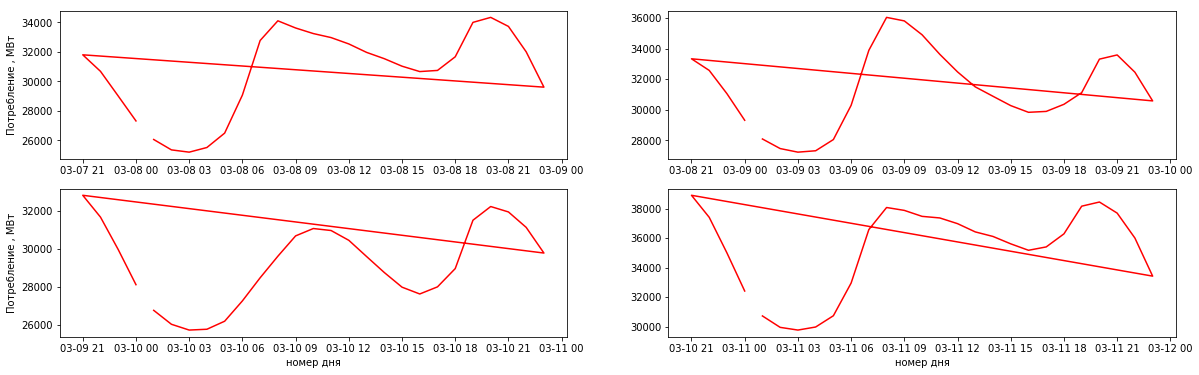

In [44]:
plt.figure(figsize=(20,6))
plt.subplot(2,2,1)
plt.plot(data['2010-03-07 21:00:00':'2010-03-8 23:00:00'].index,data['2010-03-07 21:00:00':'2010-03-08 23:00:00']['PJME_MW'].values, 'r')
plt.ylabel('Потребление , МВт')

plt.subplot(2,2,2)
plt.plot(data['2015-03-08 21:00:00':'2015-03-9 23:00:00'].index,data['2015-03-08 21:00:00':'2015-03-09 23:00:00']['PJME_MW'].values, 'r')

plt.subplot(2,2,3)
plt.plot(data['2012-03-09 21:00:00':'2012-03-10 23:00:00'].index,data['2012-03-09 21:00:00':'2012-03-10 23:00:00']['PJME_MW'].values, 'r')
plt.ylabel('Потребление , МВт')
plt.xlabel('номер дня')

plt.subplot(2,2,4)
plt.plot(data['2003-03-10 21:00:00':'2003-03-11 23:00:00'].index,data['2003-03-10 21:00:00':'2003-03-11 23:00:00']['PJME_MW'].values, 'r')
plt.xlabel('номер дня')

plt.show()

Результат ревизии нескольких дней показывает, что это постоянная картина для всего ряда. Причина в реверсивном способе дописывания дневных данных

In [45]:
data.iloc[19:26,:]

,PJME_MW,date
2002-12-31 20:00:00,32790.0,2002-12-31 20:00:00
2002-12-31 21:00:00,31336.0,2002-12-31 21:00:00
2002-12-31 22:00:00,29887.0,2002-12-31 22:00:00
2002-12-31 23:00:00,28483.0,2002-12-31 23:00:00
2003-01-01 00:00:00,27008.0,2003-01-01 00:00:00
2002-12-30 01:00:00,27526.0,2002-12-30 01:00:00
2002-12-30 02:00:00,26600.0,2002-12-30 02:00:00


Данные от 2003-01-01 00:00:00 записаны между 31.12.2002 и 30.12.2002. Принципиально при оценки статистики это не очень страшно, но порядок передачи информации важен когда мы начинаем рассматривать данные по порядку записи и отображать их на график. Для исключения нарушения порядка проведем сортировку по индексу время-дата. 

In [46]:
data = data.sort_index()

In [47]:
data.iloc[19:26,:]

,PJME_MW,date
2002-01-01 20:00:00,35639.0,2002-01-01 20:00:00
2002-01-01 21:00:00,35285.0,2002-01-01 21:00:00
2002-01-01 22:00:00,34007.0,2002-01-01 22:00:00
2002-01-01 23:00:00,31857.0,2002-01-01 23:00:00
2002-01-02 00:00:00,29563.0,2002-01-02 00:00:00
2002-01-02 01:00:00,28121.0,2002-01-02 01:00:00
2002-01-02 02:00:00,27437.0,2002-01-02 02:00:00


Теперь навели порядок в данных и посмотрим на них еще раз

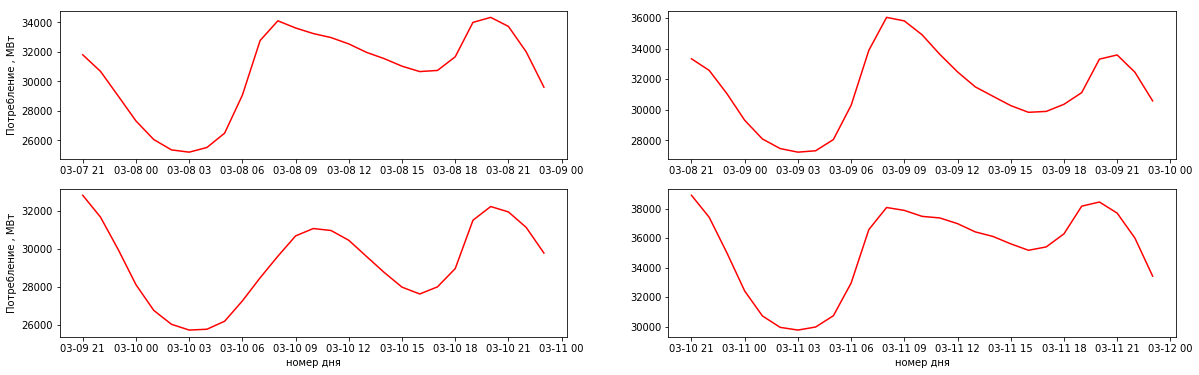

In [48]:
plt.figure(figsize=(20,6))
plt.subplot(2,2,1)
plt.plot(data['2010-03-07 21:00:00':'2010-03-8 23:00:00'].index,data['2010-03-07 21:00:00':'2010-03-08 23:00:00']['PJME_MW'].values, 'r')
plt.ylabel('Потребление , МВт')

plt.subplot(2,2,2)
plt.plot(data['2015-03-08 21:00:00':'2015-03-9 23:00:00'].index,data['2015-03-08 21:00:00':'2015-03-09 23:00:00']['PJME_MW'].values, 'r')

plt.subplot(2,2,3)
plt.plot(data['2012-03-09 21:00:00':'2012-03-10 23:00:00'].index,data['2012-03-09 21:00:00':'2012-03-10 23:00:00']['PJME_MW'].values, 'r')
plt.ylabel('Потребление , МВт')
plt.xlabel('номер дня')

plt.subplot(2,2,4)
plt.plot(data['2003-03-10 21:00:00':'2003-03-11 23:00:00'].index,data['2003-03-10 21:00:00':'2003-03-11 23:00:00']['PJME_MW'].values, 'r')
plt.xlabel('номер дня')

plt.show()

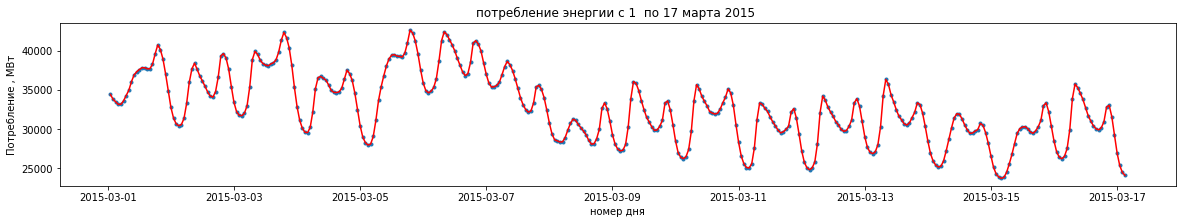

In [49]:
plt.figure(figsize=(20,3))
plt.plot(data['2015-03-01 01:00:00':'2015-03-17 03:00:00'].index,data['2015-03-01 01:00:00':'2015-03-17 03:00:00']['PJME_MW'].values, '.')
plt.plot(data['2015-03-01 01:00:00':'2015-03-17 03:00:00'].index,data['2015-03-01 01:00:00':'2015-03-17 03:00:00']['PJME_MW'].values, 'r')

plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии с 1  по 17 марта 2015 ')
plt.show()

Итак:
     - ряд исправлен,
     - все дни и часы заполнены,
     - все похоже на правду.
     
Посмотрим теперь на дату и время как на источник новых признаков.

### Добавим признаков на основе даты и времени
     
Построим еще немного признаков используя информацию о дате и времени. Воспользуемся особенностями Pandas, которая неплохо управляется с временными метками. Создадим признаки, которые описываюь дни, недели и их различные варианты (подробное описание всех вариантов можно посмотреть в https://pandas.pydata.org/pandas-docs/stable/reference/series.html#time-series-related)

In [51]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['dayofmonth'] = data['date'].dt.day
data['quarter'] = data['date'].dt.quarter
data['dayofyear'] = data['date'].dt.dayofyear
data['weekofyear'] = data['date'].dt.weekofyear
data['dayofweek'] = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour


Добавили следующие признаки:
    - номер года
    - номер месяца
    - номер дня в месяце
    - квартал
    - номер дня в году
    - номер недели в году
    - номер дня в неделе
    - час

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 10 columns):
PJME_MW       145374 non-null float64
date          145374 non-null datetime64[ns]
year          145374 non-null int64
month         145374 non-null int64
dayofmonth    145374 non-null int64
quarter       145374 non-null int64
dayofyear     145374 non-null int64
weekofyear    145374 non-null int64
dayofweek     145374 non-null int64
hour          145374 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 17.2 MB


In [53]:
data.head()

,PJME_MW,date,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
2002-01-01 01:00:00,30393.0,2002-01-01 01:00:00,2002,1,1,1,1,1,1,1
2002-01-01 02:00:00,29265.0,2002-01-01 02:00:00,2002,1,1,1,1,1,1,2
2002-01-01 03:00:00,28357.0,2002-01-01 03:00:00,2002,1,1,1,1,1,1,3
2002-01-01 04:00:00,27899.0,2002-01-01 04:00:00,2002,1,1,1,1,1,1,4
2002-01-01 05:00:00,28057.0,2002-01-01 05:00:00,2002,1,1,1,1,1,1,5


Информация в нашем случае относится к часам, дням , месяцам и т.д. Давайте для работы с датами добавим новый уровень индексов, перейдем к мультииндексам по 2-м категориям ['Date','Time']

In [54]:
data_i=pd.MultiIndex.from_arrays([data.index.date, data.index.time], names=['Date','Time'])
data.index = data_i
data.head()

PJME_MW                date  year  month  dayofmonth  \
Date       Time                                                             
2002-01-01 01:00:00  30393.0 2002-01-01 01:00:00  2002      1           1   
           02:00:00  29265.0 2002-01-01 02:00:00  2002      1           1   
           03:00:00  28357.0 2002-01-01 03:00:00  2002      1           1   
           04:00:00  27899.0 2002-01-01 04:00:00  2002      1           1   
           05:00:00  28057.0 2002-01-01 05:00:00  2002      1           1   

                     quarter  dayofyear  weekofyear  dayofweek  hour  
Date       Time                                                       
2002-01-01 01:00:00        1          1           1          1     1  
           02:00:00        1          1           1          1     2  
           03:00:00        1          1           1          1     3  
           04:00:00        1          1           1          1     4  
           05:00:00        1          1           1          1     5

In [55]:
data.iloc[data.index.get_level_values('Date') == '2012-10-30']

PJME_MW                date  year  month  dayofmonth  \
Date       Time                                                             
2012-10-30 00:00:00  15919.0 2012-10-30 00:00:00  2012     10          30   
           01:00:00  15390.0 2012-10-30 01:00:00  2012     10          30   
           02:00:00  14955.0 2012-10-30 02:00:00  2012     10          30   
           03:00:00  14586.0 2012-10-30 03:00:00  2012     10          30   
           04:00:00  14544.0 2012-10-30 04:00:00  2012     10          30   
           05:00:00  14821.0 2012-10-30 05:00:00  2012     10          30   
           06:00:00  15526.0 2012-10-30 06:00:00  2012     10          30   
           07:00:00  16688.0 2012-10-30 07:00:00  2012     10          30   
           08:00:00  17734.0 2012-10-30 08:00:00  2012     10          30   
           09:00:00  18675.0 2012-10-30 09:00:00  2012     10          30   
           10:00:00  19775.0 2012-10-30 10:00:00  2012     10          30   
           11:00:00  20815.0 2012-10-30 11:00:00  2012     10          30   
           12:00:00  21428.0 2012-10-30 12:00:00  2012     10          30   
           13:00:00  21802.0 2012-10-30 13:00:00  2012     10          30   
           14:00:00  21978.0 2012-10-30 14:00:00  2012     10          30   
           15:00:00  22065.0 2012-10-30 15:00:00  2012     10          30   
           16:00:00  22260.0 2012-10-30 16:00:00  2012     10          30   
           17:00:00  22810.0 2012-10-30 17:00:00  2012     10          30   
           18:00:00  23708.0 2012-10-30 18:00:00  2012     10          30   
           19:00:00  24817.0 2012-10-30 19:00:00  2012     10          30   
           20:00:00  24824.0 2012-10-30 20:00:00  2012     10          30   
           21:00:00  24344.0 2012-10-30 21:00:00  2012     10          30   
           22:00:00  23268.0 2012-10-30 22:00:00  2012     10          30   
           23:00:00  21725.0 2012-10-30 23:00:00  2012     10          30   

                     quarter  dayofyear  weekofyear  dayofweek  hour  
Date       Time                                                       
2012-10-30 00:00:00        4        304          44          1     0  
           01:00:00        4        304          44          1     1  
           02:00:00        4        304          44          1     2  
           03:00:00        4        304          44          1     3  
           04:00:00        4        304          44          1     4  
           05:00:00        4        304          44          1     5  
           06:00:00        4        304          44          1     6  
           07:00:00        4        304          44          1     7  
           08:00:00        4        304          44          1     8  
           09:00:00        4        304          44          1     9  
           10:00:00        4        304          44          1    10  
           11:00:00        4        304          44          1    11  
           12:00:00        4        304          44          1    12  
           13:00:00        4        304          44          1    13  
           14:00:00        4        304          44          1    14  
           15:00:00        4        304          44          1    15  
           16:00:00        4        304          44          1    16  
           17:00:00        4        304          44          1    17  
           18:00:00        4        304          44          1    18  
           19:00:00        4        304          44          1    19  
           20:00:00        4        304          44          1    20  
           21:00:00        4        304          44          1    21  
           22:00:00        4        304          44          1    22  
           23:00:00        4        304          44          1    23

In [59]:
# теперь уберем служебную колонку data
data.drop( columns = 'date', inplace = True )
data.head()

PJME_MW  year  month  dayofmonth  quarter  dayofyear  \
Date       Time                                                             
2002-01-01 01:00:00  30393.0  2002      1           1        1          1   
           02:00:00  29265.0  2002      1           1        1          1   
           03:00:00  28357.0  2002      1           1        1          1   
           04:00:00  27899.0  2002      1           1        1          1   
           05:00:00  28057.0  2002      1           1        1          1   

                     weekofyear  dayofweek  hour  is_holiday  is_prev_holiday  \
Date       Time                                                                 
2002-01-01 01:00:00           1          1     1           1                0   
           02:00:00           1          1     2           1                0   
           03:00:00           1          1     3           1                0   
           04:00:00           1          1     4           1                0   
           05:00:00           1          1     5           1                0   

                     is_next_holiday  
Date       Time                       
2002-01-01 01:00:00                0  
           02:00:00                0  
           03:00:00                0  
           04:00:00                0  
           05:00:00                0

Попробуем добавить информацию о праздинках и особенностях календаря. Поскольку ряд относится к работе электросетей США, то это очень легко реализовать импортировав соответствующий модуль pandas.tseries.holiday. Он содержит несколько вариантов календаря для США и предоставляет возможность построить свой календарь на основе абстрактного (пример работы в https://qa-help.ru/questions/sozdajte-prazdnichnyj-kalendar-prazdnikov-s-pandas). 

Календарь - это объект типа DatetimeIndex, который содержит список праздничных дней.

Воспользуемся доступным USFederalHolidayCalendar. Для работы с календарем удобно пользоваться механизмом определения интервалов времени по датам timedelta из  datetime.  Импортируем все и создадим еще признаков с метками праздников.  Добавим не только сами праздники, но пометим дни до и после (по одному дню)

In [60]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta
one_day = timedelta(days=1)
cal = calendar()
#инициализировали объект календарь
data['is_holiday'] = data.index.get_level_values('Date').isin([d.date() for d in cal.holidays()])
data['is_prev_holiday'] = data.index.get_level_values('Date').isin([( d.date() - one_day ) for d in cal.holidays()])
data['is_next_holiday'] = data.index.get_level_values('Date').isin([( d.date() + one_day ) for d in cal.holidays()])
data['is_holiday'] = data['is_holiday'].astype('uint8')
data['is_prev_holiday'] = data['is_prev_holiday'].astype('uint8')
data['is_next_holiday'] = data['is_next_holiday'].astype('uint8')


Наша таблица станет большой, очень большой и сложной!!

In [61]:
data.head()

PJME_MW  year  month  dayofmonth  quarter  dayofyear  \
Date       Time                                                             
2002-01-01 01:00:00  30393.0  2002      1           1        1          1   
           02:00:00  29265.0  2002      1           1        1          1   
           03:00:00  28357.0  2002      1           1        1          1   
           04:00:00  27899.0  2002      1           1        1          1   
           05:00:00  28057.0  2002      1           1        1          1   

                     weekofyear  dayofweek  hour  is_holiday  is_prev_holiday  \
Date       Time                                                                 
2002-01-01 01:00:00           1          1     1           1                0   
           02:00:00           1          1     2           1                0   
           03:00:00           1          1     3           1                0   
           04:00:00           1          1     4           1                0   
           05:00:00           1          1     5           1                0   

                     is_next_holiday  
Date       Time                       
2002-01-01 01:00:00                0  
           02:00:00                0  
           03:00:00                0  
           04:00:00                0  
           05:00:00                0

Посмотрим на сам календарь. Это всего лишь аккуратно оформленный список праздников за 60 лет. 

In [62]:
cal.holidays()

DatetimeIndex(['1970-01-01', '1970-02-16', '1970-05-25', '1970-07-03',
               '1970-09-07', '1970-10-12', '1970-11-11', '1970-11-26',
               '1970-12-25', '1971-01-01',
               ...
               '2030-01-01', '2030-01-21', '2030-02-18', '2030-05-27',
               '2030-07-04', '2030-09-02', '2030-10-14', '2030-11-11',
               '2030-11-28', '2030-12-25'],
              dtype='datetime64[ns]', length=594, freq=None)

Отобразим дни с 1-го по 7-е января 2002. Отметим сам праздничный день (красные точки) и день после праздника (синий крестик)

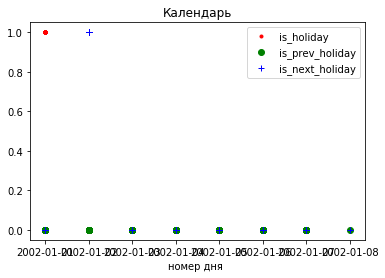

In [63]:
plt.plot(data.iloc[:7*24].index.get_level_values('Date'),data['is_holiday'].values[:7*24],'.r',label = 'is_holiday')
plt.plot(data.iloc[:7*24].index.get_level_values('Date'),data['is_prev_holiday'].values[:7*24],'og',label = 'is_prev_holiday')
plt.plot(data.iloc[:7*24].index.get_level_values('Date'), data['is_next_holiday'].values[:7*24],'+b',label = 'is_next_holiday')
plt.legend()
plt.title('Календарь')
plt.xlabel('номер дня ')
plt.show()

Подведем некоторые итоги обработки признаков:
    -  Построили дополнительные признаки - обобщение времени в неделях, недельных циклах (номера дней недели), сезонных циклах в кварталах и месяцах. Скорее всего использовать их напрямую будет сложно, т.к. они имеют разный масштаб изменения значений, но они несколько изменят картину времени в нашей модели и сделают ее более сложной.
    - Помимо упорядоченых по времени меток, введены метки категории (фактически это dummy-переменные для обозначения праздничных дней).
    - Можно подумать о поиске какой-то модели глобальных событий, например биржевых индексов, для увеличения пространства и введения новых факторов. 
    - Можно добавить полностью фиктивные переменные поскольку очевидно есть факты, которые мы не учли.
    - Следует помнить, что увеличение пространства признаков приводит к увеличению модели, которая формируется при построении регрессора, а значит и времени обучения и тестирования. Поэтому остановим процесс расширения пространства доступных входных признаков и перейдем к разработке модели.

Можем попробовать создать модель Потребления энергии для сформированного описания.   

## Разделение данных на тестовые и тренировочные во временных рядах

В классификаторе правильная модель разделения должна обеспечить одинаковое распределение примеров в пространстве признаков в тестовой и тренировочной выборках.Во временных рядах это не имеет смысла, т.к. предсказывая следующее значение необходимо использовать уже известную информацию. Поличить доступ к данным из будущего у нас нет возможности (если бы мы могли предсказать сколько ест котенок, когда подрастает, мы бы сразу нашли вторую работу). Это приводит к тому, что тестовая выборка при построении модели во временных рядах идет за массивом данных для тренировки. Пример такого разделения приведен ниже   

In [64]:
# сделаем функцию и 
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

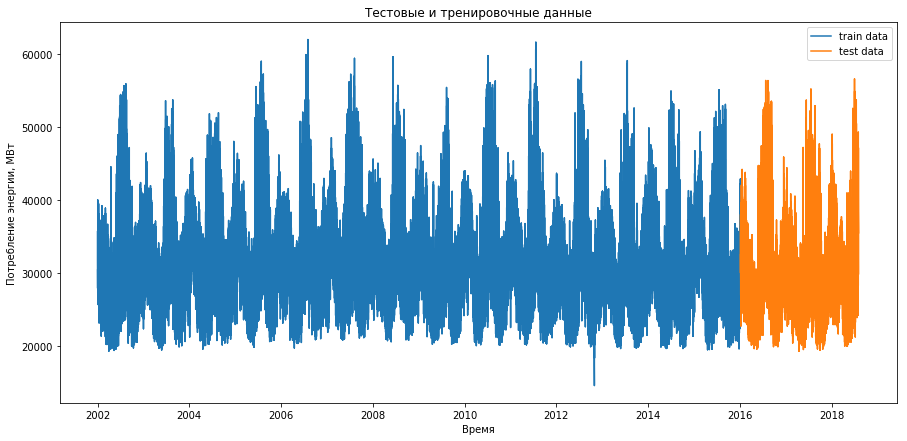

In [65]:
train, test = split_data( data, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [66]:
train.head()

PJME_MW  year  month  dayofmonth  quarter  dayofyear  \
Date       Time                                                             
2002-01-01 01:00:00  30393.0  2002      1           1        1          1   
           02:00:00  29265.0  2002      1           1        1          1   
           03:00:00  28357.0  2002      1           1        1          1   
           04:00:00  27899.0  2002      1           1        1          1   
           05:00:00  28057.0  2002      1           1        1          1   

                     weekofyear  dayofweek  hour  is_holiday  is_prev_holiday  \
Date       Time                                                                 
2002-01-01 01:00:00           1          1     1           1                0   
           02:00:00           1          1     2           1                0   
           03:00:00           1          1     3           1                0   
           04:00:00           1          1     4           1                0   
           05:00:00           1          1     5           1                0   

                     is_next_holiday  
Date       Time                       
2002-01-01 01:00:00                0  
           02:00:00                0  
           03:00:00                0  
           04:00:00                0  
           05:00:00                0

Теперь выделим описание объекта и целевое свойство 

In [67]:
X_train = train
y_train = train['PJME_MW'].values
X_test = test
y_test = test['PJME_MW'].values
X_train.drop( columns = 'PJME_MW', inplace = True )
X_test.drop( columns = 'PJME_MW', inplace = True )


# Строим Модель

Модель собираем в трех сравнительно стандартных вариантах(линейная регресси, случайный лес и градиентный бустинг). Пока нет цели получить идеальный результат. Необходимо понять, хорошее ли представление ситуации мы сделали и можно ли вообще построить в таком описании адекватный ответ. Импортируем необходимые модели.

In [68]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


Все модели возьмем в варианте параметров по умолчанию.

In [69]:
model_l = LinearRegression()
model_f = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [70]:
model_l.fit( X_train, y_train )
model_f.fit( X_train, y_train )
model_g.fit( X_train, y_train ) # 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [71]:
X_test_pred_l = model_l.predict(X_test)
X_test_pred_f = model_f.predict(X_test)
X_test_pred_g = model_g.predict(X_test)

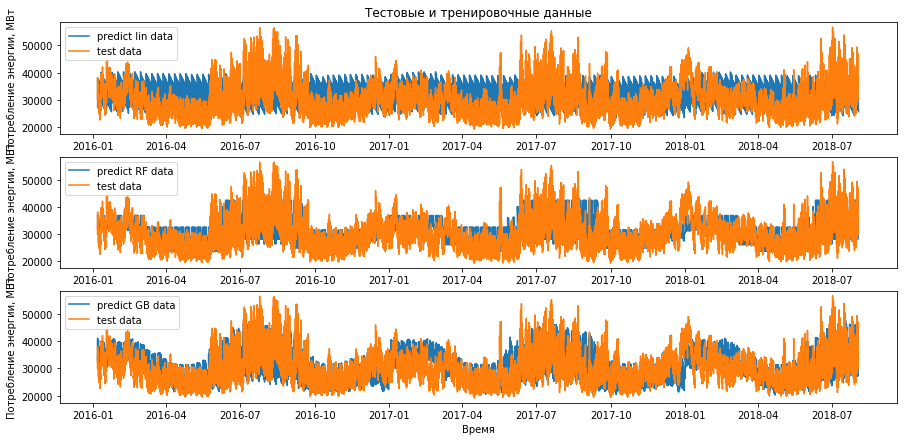

In [72]:

plt.figure( figsize=( 15, 7 ))
plt.subplot(3,1,1)

plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index.get_level_values('Date'),X_test_pred_l, label='predict lin data' )
plt.plot(test.index.get_level_values('Date'),y_test, label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.subplot(3,1,2)

plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index.get_level_values('Date'),X_test_pred_f, label='predict RF data' )
plt.plot(test.index.get_level_values('Date'),y_test, label='test data')

plt.legend()
plt.subplot(3,1,3)
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index.get_level_values('Date'),X_test_pred_g, label='predict GB data' )
plt.plot(test.index.get_level_values('Date'),y_test, label='test data')

plt.legend()
plt.show()

На уровне визуального анализа модель на основе случайного леса и градиентного бустинга выглядят более интересными, линейная регрессия не показывает длинные циклы годового изменения потребления. Оценим в цифрах промах моделей

**Средне Квадратичное Отклонение - Mean Square Error**

In [73]:
er_l = mean_squared_error(y_true=y_test, y_pred=X_test_pred_l) 
er_f = mean_squared_error(y_true=y_test, y_pred=X_test_pred_f) 
er_g = mean_squared_error(y_true=y_test, y_pred=X_test_pred_g)

print('ошибка линейной регрессии :  ', er_l,'\nошибка случайного леса  :  ', er_f,'\nошибка градиентного бустинга :  ', er_g)

ошибка линейной регрессии :   32612765.983144023 
ошибка случайного леса  :   19077493.471936233 
ошибка градиентного бустинга :   16919827.6796856


Очевидно, что градиентынй бустинг победил со значительным отрывом. Однако можно проверить другую оценку, которая соотносит размер промаха с абсолютным значением целевого сигнала. Это средняя абсолютная процентная ошибка (MAPE)

In [74]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [75]:

er_l = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_l) 
er_f = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_f) 
er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_g)

print('ошибка линейной регрессии :  ', er_l,'\nошибка случайного леса  :  ', er_f,'\nошибка градиентного бустинга :  ', er_g)

ошибка линейной регрессии :   15.001295564754653 
ошибка случайного леса  :   11.390147545235232 
ошибка градиентного бустинга :   10.105708620380426


Отрыв градиентного бустинга сохраняется, но и случайный лес выглядит неплохо. 

События во временном ряду Потребление энергии развиваются сравнительно просто, посмотрим как будет работать  оценка временного ряда "Цена нефти Brent" 


## BRENT

Повторим все операции для второго ряда. Начиная от проверки содержания измерений и заканчивая построением модели.

In [76]:
brent_data.describe()

,Значение
count,2667.000000
mean,81.533547
std,26.349469
min,27.850000
25%,56.840000
50%,77.710000
75%,108.190000
max,126.900000


In [77]:
# unique index
brent_data.index.nunique() == brent_data.shape[0]

True

Повтора индексов нет, т.к. число измерений и число уникальных индексов по времени совпадает. Отсортируем ряд по времени и нарисуем

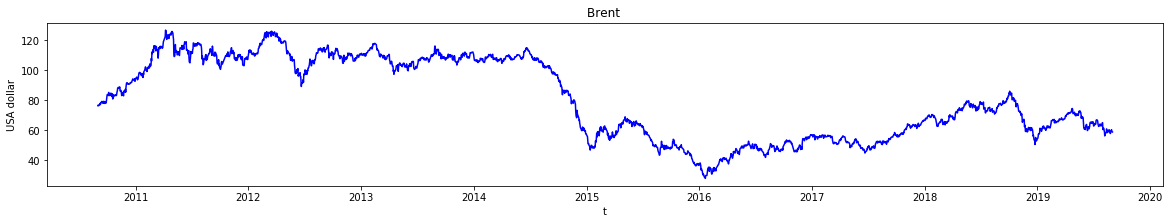

In [78]:
brent_data  = brent_data.sort_index()
plt.figure( figsize=( 20, 3))
plt.plot(brent_data.index, brent_data['Значение'],'b' )
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.title('Brent ')
plt.show()

Добавим метки по календарю, хотя практически очевидно, что они слабо влияют на стоимость нефти.

In [79]:
brent_data['data'] = brent_data.index
brent_data['year'] = brent_data['data'].dt.year
brent_data['month'] = brent_data['data'].dt.month
brent_data['dayofmonth'] = brent_data['data'].dt.day
brent_data['quarter'] = brent_data['data'].dt.quarter
brent_data['dayofyear'] = brent_data['data'].dt.dayofyear
brent_data['weekofyear'] = brent_data['data'].dt.weekofyear
brent_data['dayofweek'] = brent_data['data'].dt.dayofweek


In [80]:
brent_data['is_holiday'] = brent_data.index.isin([d.date() for d in cal.holidays()])
brent_data['is_prev_holiday'] = brent_data.index.isin([( d.date() - one_day ) for d in cal.holidays()])
brent_data['is_next_holiday'] = brent_data.index.isin([( d.date() + one_day ) for d in cal.holidays()])
brent_data['is_holiday'] = brent_data['is_holiday'].astype('uint8')
brent_data['is_prev_holiday'] = brent_data['is_prev_holiday'].astype('uint8')
brent_data['is_next_holiday'] = brent_data['is_next_holiday'].astype('uint8')

In [81]:
brent_data = brent_data.drop('data', axis = 1)
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Строим модель для разделенных на тест и тренировочный набор данных (дата разделения 10.10.2018)

In [82]:
# сделаем функцию 
def split_data_b( data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [83]:
train_b, test_b = split_data_b( brent_data, '10-10-2018')

X_train_b = train_b
y_train_b = train_b['Значение'].values
X_test_b = test_b
y_test_b = test_b['Значение'].values
X_train_b.drop( columns = 'Значение', inplace = True )
X_test_b.drop( columns = 'Значение', inplace = True )


In [84]:
model_lb = LinearRegression()
model_fb = RandomForestRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [85]:
model_lb.fit( X_train_b, y_train_b )
model_fb.fit( X_train_b, y_train_b )
model_gb.fit( X_train_b, y_train_b ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
X_test_pred_lb = model_lb.predict(X_test_b)
X_test_pred_fb = model_fb.predict(X_test_b)
X_test_pred_gb = model_gb.predict(X_test_b)

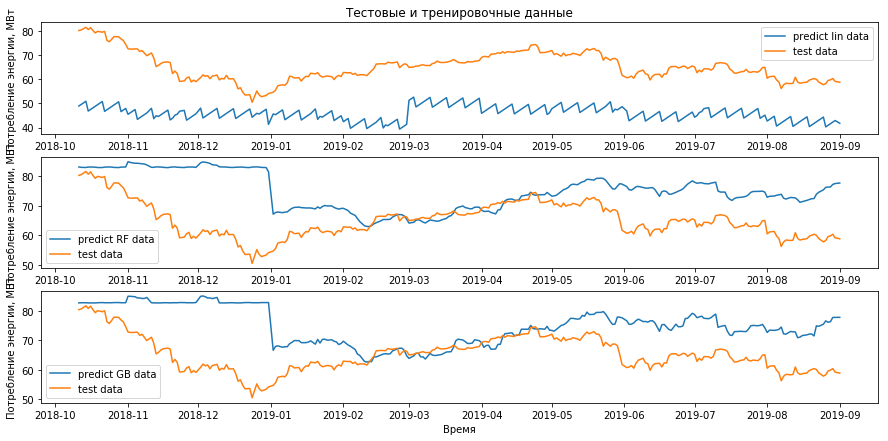

In [87]:
plt.figure( figsize=( 15, 7 ))
plt.subplot(3,1,1)

plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index,X_test_pred_lb, label='predict lin data' )
plt.plot(test_b.index,y_test_b, label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.subplot(3,1,2)

plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index,X_test_pred_fb, label='predict RF data' )
plt.plot(test_b.index,y_test_b, label='test data')

plt.legend()
plt.subplot(3,1,3)
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index,X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index,y_test_b, label='test data')

plt.legend()
plt.show()

Рассмотрим результаты моделирования. Очевидно, что качество предсказания значительно хуже, чем было у первой модели. Причем размеры регрессоров формально значительно больше. Однако, качество решения у всех трех регрессоров очень не высокое. 

Возникает вопрос, почему одинаковая обработка не позволила увидеть одинаковое качество?

### :(

Напрашивается простой вывод - ряды сильно отличаются друг от друга. Перый ряд повторяемый, а второй не очень.



Таким образом, в рамках первичного анализа:
- НЕЛЬЗЯ НАДЕЯТЬСЯ НА ИДЕАЛЬНЫЕ ДАННЫЕ,
- НЕОБХОДИМО СЛЕДИТЬ ЗА МЕТКАМИ ВРЕМЕНИ,
- НЕОБХОДИМО ПРОВЕРЯТЬ ВЫБРОСЫ И ПРОПУСКИ,
- ИМЕЕТ СМЫСЛ ВВОДИТЬ В ОПИСАНИЕ ЯВЛЕНИЯ, КОТОРОЕ ОТОБРАЖАЕТ РЯД ДОПОЛНИТЕЛЬНЫЕ ПРИЗНАКИ (НЕ ОБЯЗАТЕЛЬНО ПРАЗДНИКИ И НОМЕРА НЕДЕЛЬ, МОЖНО ИСПОЛЬЗОВАТЬ ДРУГИЕ ВАРИАНТЫ )
- НУЖНО СТРОИТЬ ПРОСТЫЕ МОДЕЛИ ПРЕЖДЕ ЧЕМ ПЕРЕХОДИТЬ К НАСТРОЙКЕ ГИПЕРПАРАМТРОВ.
- НУЖНО ВВЕСТИ ИСТОРИЧЕСКИЕ ДАННЫЕ, Т.Е. КРОМЕ ПРЯМЫХ ХАРАКТЕРИСТИК СИТУАЦИИ, НУЖНО ВВОДИТЬ ПРЕДШЕСТВУЮЩИЕ ЗНАЧЕНИЯ ВРЕМЕННОГО РЯДА ИЛИ КАКИЕ-ТО ФУНКЦИИ ОТ ЭТИХ ЗНАЧЕКНИЙ.

В следующей части обсудим задачу оценки характера временного ряда и способов его обработки в зависимости от характера.

## Задание

1. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

2. Прочитайте базу Brent и сделайте ее перрасчет (ресемплинг) в представление по неделям , по месяцам.

3. Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.

4. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.